<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/ViT_crp1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/crp>1.0/image_crp1.0_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 6.5 MB/s eta 0:00:00


In [3]:
batch_size=16 #バッチサイズ(batch size)
epochs = 110
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダの定義
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)  # 検証中はシャッフル不要
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # テストデータもシャッフル不要

model_names = timm.list_models(pretrained=True)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
#pprint(model_names)
#model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
#model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
# 訓練済みデータを使用しない場合はpretrained=Falseとする。訓練済みデータを使用し、ファインチューニングしたい場合はpretrained=True
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

学習ループを設定し、実行していく

In [4]:
import gc # Garbage Collectionモジュールをインポート
from torchvision.utils import make_grid
train_acc_list = []
val_acc_list = []
test_acc_list = []
train_loss_list = []
val_loss_list = []
test_loss_list = []

    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    #ここからが検証用データの解析
    with torch.no_grad():#勾配の計算を無効にするコンテキストマネージャ。モデルを評価する際には、勾配の計算は不要であり、計算量を削減することができる。
        epoch_val_accuracy = 0#各エポックの初めで、検証したエポックの正確さをゼロに初期化する。
        epoch_val_loss = 0#各エポックの初めで、検証したエポックの損失をゼロに初期化する。
        for data, label in valid_loader:#検証データローダーからバッチを取得する。
            data = data.to(device)#取得した画像をGPUに移す
            label = label.to(device)#取得したラベルをGPUに移す
        #以降の部分は基本的に訓練ループと同じ。
        #ただし、検証過程ではモデルのパラメータを更新する必要がないため、optimizer.zero_grad(), loss.backward(), optimizer.step()の部分は含まれていない。
            val_output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
            val_loss = criterion(val_output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

            acc = (val_output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。
            epoch_val_accuracy += acc / len(valid_loader)#バッチごとの正確さを加算する。
            epoch_val_loss += val_loss / len(valid_loader)#バッチごとの損失を加算する。

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

# すべての変数を削除してメモリを解放します！
del data, label, output, loss, acc
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 - loss : 5.5934 - acc: 0.5862 - val_loss : 0.6376 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8617 - acc: 0.6017 - val_loss : 0.6863 - val_acc: 0.7869



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6535 - acc: 0.6992 - val_loss : 0.6243 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7599 - acc: 0.5733 - val_loss : 0.8329 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7333 - acc: 0.5987 - val_loss : 0.6429 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.7231 - acc: 0.6733 - val_loss : 0.5750 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7105 - acc: 0.6862 - val_loss : 0.5663 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5931 - acc: 0.7354 - val_loss : 0.6641 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6687 - acc: 0.7354 - val_loss : 0.5832 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6297 - acc: 0.7358 - val_loss : 0.5951 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5674 - acc: 0.7350 - val_loss : 0.6050 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5897 - acc: 0.7367 - val_loss : 0.6088 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6749 - acc: 0.6238 - val_loss : 0.8474 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.7400 - acc: 0.6488 - val_loss : 0.9528 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.7277 - acc: 0.6867 - val_loss : 0.5604 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.7123 - acc: 0.6554 - val_loss : 0.5936 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6733 - acc: 0.7054 - val_loss : 0.5789 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6781 - acc: 0.5971 - val_loss : 0.5637 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5840 - acc: 0.7354 - val_loss : 0.5812 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5887 - acc: 0.7354 - val_loss : 0.5754 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5780 - acc: 0.7362 - val_loss : 0.5855 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5983 - acc: 0.7358 - val_loss : 0.5983 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5952 - acc: 0.7358 - val_loss : 0.5938 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6243 - acc: 0.6858 - val_loss : 0.6368 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6544 - acc: 0.6921 - val_loss : 0.7055 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6876 - acc: 0.6362 - val_loss : 0.5872 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6997 - acc: 0.6729 - val_loss : 0.6028 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6756 - acc: 0.7346 - val_loss : 0.6499 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6132 - acc: 0.7350 - val_loss : 0.5667 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5919 - acc: 0.7367 - val_loss : 0.5658 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6836 - acc: 0.5608 - val_loss : 0.7893 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.7391 - acc: 0.6642 - val_loss : 0.6103 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5648 - acc: 0.7371 - val_loss : 0.5592 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5952 - acc: 0.7354 - val_loss : 0.5585 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6209 - acc: 0.7367 - val_loss : 0.6005 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5931 - acc: 0.7354 - val_loss : 0.5578 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5764 - acc: 0.7358 - val_loss : 0.5556 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6224 - acc: 0.7554 - val_loss : 0.5588 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5996 - acc: 0.7371 - val_loss : 0.5574 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5762 - acc: 0.7358 - val_loss : 0.5530 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5683 - acc: 0.7354 - val_loss : 0.5672 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.6022 - acc: 0.7354 - val_loss : 0.7966 - val_acc: 0.3478



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5521 - acc: 0.7179 - val_loss : 0.7293 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6392 - acc: 0.6746 - val_loss : 0.5661 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5783 - acc: 0.7362 - val_loss : 0.5611 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5976 - acc: 0.7179 - val_loss : 0.5843 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6665 - acc: 0.7104 - val_loss : 0.5564 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5805 - acc: 0.7167 - val_loss : 0.6332 - val_acc: 0.6987



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5730 - acc: 0.7350 - val_loss : 0.5751 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5874 - acc: 0.7179 - val_loss : 0.5610 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.6262 - acc: 0.6600 - val_loss : 0.5450 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5579 - acc: 0.7292 - val_loss : 0.5772 - val_acc: 0.7612



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.6477 - acc: 0.6467 - val_loss : 0.6711 - val_acc: 0.5962



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5872 - acc: 0.7271 - val_loss : 0.5670 - val_acc: 0.7708



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.6543 - acc: 0.6408 - val_loss : 0.5508 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5842 - acc: 0.6612 - val_loss : 0.7790 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.7196 - acc: 0.6271 - val_loss : 0.6136 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6071 - acc: 0.7354 - val_loss : 0.5668 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.6540 - acc: 0.7088 - val_loss : 0.6140 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5917 - acc: 0.7358 - val_loss : 0.5487 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5697 - acc: 0.7429 - val_loss : 0.5480 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5853 - acc: 0.7350 - val_loss : 0.5396 - val_acc: 0.7708



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5029 - acc: 0.7737 - val_loss : 0.6376 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.6297 - acc: 0.7050 - val_loss : 0.5471 - val_acc: 0.7708



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5930 - acc: 0.7358 - val_loss : 0.5716 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5573 - acc: 0.7300 - val_loss : 0.5404 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5262 - acc: 0.7608 - val_loss : 0.5341 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5261 - acc: 0.7425 - val_loss : 0.5683 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5583 - acc: 0.7175 - val_loss : 0.5842 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5361 - acc: 0.7546 - val_loss : 0.5419 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5301 - acc: 0.7421 - val_loss : 0.7539 - val_acc: 0.5128



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5716 - acc: 0.7367 - val_loss : 0.5323 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5201 - acc: 0.7487 - val_loss : 0.5251 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5105 - acc: 0.7346 - val_loss : 0.5744 - val_acc: 0.6939



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5552 - acc: 0.7050 - val_loss : 0.5147 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.4917 - acc: 0.7675 - val_loss : 0.5246 - val_acc: 0.7452



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5370 - acc: 0.7475 - val_loss : 0.5971 - val_acc: 0.6218



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5257 - acc: 0.7242 - val_loss : 0.5559 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5309 - acc: 0.7679 - val_loss : 0.5057 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.4990 - acc: 0.7550 - val_loss : 0.5454 - val_acc: 0.6939



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4786 - acc: 0.8242 - val_loss : 0.6216 - val_acc: 0.6891



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.5461 - acc: 0.7733 - val_loss : 0.5047 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5191 - acc: 0.7671 - val_loss : 0.5226 - val_acc: 0.7708



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5874 - acc: 0.7492 - val_loss : 0.5720 - val_acc: 0.7821



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.5084 - acc: 0.7679 - val_loss : 0.5247 - val_acc: 0.7869



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.6001 - acc: 0.7050 - val_loss : 0.5004 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5290 - acc: 0.7425 - val_loss : 0.5168 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.5346 - acc: 0.7675 - val_loss : 0.5079 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.5552 - acc: 0.7042 - val_loss : 0.5093 - val_acc: 0.7147



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5363 - acc: 0.7358 - val_loss : 0.5565 - val_acc: 0.7356



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5196 - acc: 0.7412 - val_loss : 0.5234 - val_acc: 0.8125



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.4664 - acc: 0.7925 - val_loss : 0.5155 - val_acc: 0.6987



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5262 - acc: 0.7433 - val_loss : 0.4998 - val_acc: 0.7660



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.4987 - acc: 0.7679 - val_loss : 0.5150 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5266 - acc: 0.7350 - val_loss : 0.5429 - val_acc: 0.7660



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5624 - acc: 0.7483 - val_loss : 0.5188 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5116 - acc: 0.7429 - val_loss : 0.5147 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5046 - acc: 0.7550 - val_loss : 0.5374 - val_acc: 0.7452



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5064 - acc: 0.7608 - val_loss : 0.5613 - val_acc: 0.7612



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5209 - acc: 0.7296 - val_loss : 0.4932 - val_acc: 0.7452



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5379 - acc: 0.7242 - val_loss : 0.5533 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.6106 - acc: 0.6596 - val_loss : 0.6193 - val_acc: 0.6635



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.5505 - acc: 0.7425 - val_loss : 0.5134 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.5170 - acc: 0.7613 - val_loss : 0.5231 - val_acc: 0.7708



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.5358 - acc: 0.7675 - val_loss : 0.5784 - val_acc: 0.6731



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.5408 - acc: 0.7425 - val_loss : 0.5137 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.4903 - acc: 0.7746 - val_loss : 0.4933 - val_acc: 0.7917



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.5360 - acc: 0.7438 - val_loss : 0.5483 - val_acc: 0.7147



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.5005 - acc: 0.7242 - val_loss : 0.5646 - val_acc: 0.7500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.5173 - acc: 0.7550 - val_loss : 0.6256 - val_acc: 0.7708



180

In [5]:
#ここからが試験データの解析
import gc # Garbage Collectionモジュールをインポート
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(test_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(test_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。
        # バッチの反復処理の最後にキャッシュをクリアします！
        del data, label, output, loss, acc # すべての変数を削除してメモリを解放します！
        torch.cuda.empty_cache()
        gc.collect()
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n"
    )
    test_acc_list.append(epoch_accuracy)
    test_loss_list.append(epoch_loss)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.7398 - acc: 4.1250



  0%|          | 0/12 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 24.81 MiB is free. Process 24501 has 39.53 GiB memory in use. Of the allocated memory 37.46 GiB is allocated by PyTorch, and 1.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 学習結果の可視化

<ipython-input-5-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


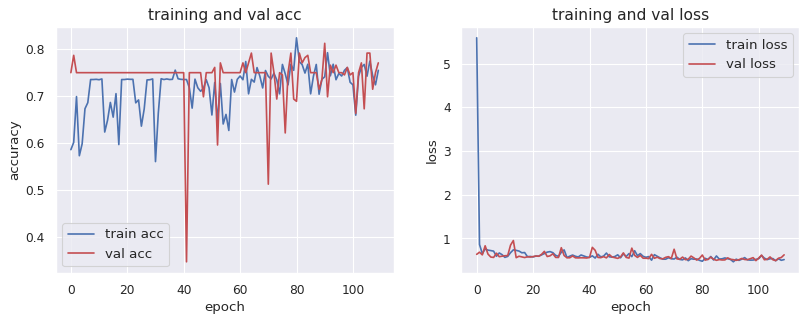

In [5]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/OptPhotoFiles/model_checkpoint2'
torch.save(model.state_dict(), model_save_path)

In [ ]:


# 2. 学習されたモデルでGradCamを適用
class GradCam:
    def __init__(self, model):
        self.model = model
        self.feature = None
        self.gradient = None

        # フォワード時のhook
        def forward_hook(module, input, output):
            self.feature = output

        # バックワード時のhook
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0]

        # 最終層の途中の特徴マップを取得するレイヤーを指定してhookを設定
        self.model.head.dist_token.register_forward_hook(forward_hook)
        self.model.head.dist_token.register_backward_hook(backward_hook)

    def __call__(self, x):
        self.feature = None
        self.gradient = None
        output = self.model(x)
        score = output[:, output.argmax(1)].squeeze()
        self.model.zero_grad()
        score.backward(torch.ones_like(score))
        gradient = self.gradient[0]
        weight = gradient.mean(dim=[2, 3], keepdim=True)
        cam = F.relu((weight * self.feature).sum(dim=1)).squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

grad_cam = GradCam(model)

# 3. ヒートマップを元の画像にオーバーレイして表示
def overlay_heatmap_to_image(image, heatmap):
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    return overlayed

# 適当な画像を選択
images, _ = next(iter(test_loader))
images = images[:5]  # 5枚を選択
heatmaps = [grad_cam(img.unsqueeze(0)) for img in images]
overlayed_imgs = [overlay_heatmap_to_image(img.permute(1, 2, 0).numpy(), heatmap) for img, heatmap in zip(images, heatmaps)]

# 表示
grid_img = make_grid(torch.tensor(overlayed_imgs).permute(0, 3, 1, 2))
plt.figure(figsize=(15, 15))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()